## Feature engineering

In [1]:
# Load pyspark
import findspark

findspark.init()

#import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession, functions as F, window

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler, Bucketizer
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

import os
import shutil

import datetime
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

spark = SparkSession.builder.appName("dengue").getOrCreate()

### Chargement des données pré-traitées

In [2]:
df_train = spark.read.parquet("data/01-preprocessed")

print("df_train = ({}, {})".format(df_train.count(), len(df_train.columns)))

df_train = (1456, 24)


### Construction de nouvelles variables

#### Végétation

NDVI Normalized difference vegetation index (NDVI) indique l'indice de végétation :
- en dessous de -0.1 il s'agit probablement d'eau
- entre -0.1 et 0.1 urbanisé ou pierre ou minéral ou terre nue
- entre 0.1 et 0.4 végétation peu dense
- au dessus de 0.4 végétation dense


(à noter que les seuils ne sont pas toujours très bien définis...)

In [3]:
def ndvi_bucketize(df):
    splits = [-float("inf"), -0.1, 0.1, 0.4, float("inf")]

    bucketizer_ne = Bucketizer(splits=splits, inputCol='ndvi_ne', outputCol='bucket_ne')
    bucketizer_nw = Bucketizer(splits=splits, inputCol='ndvi_nw', outputCol='bucket_nw')
    bucketizer_sw = Bucketizer(splits=splits, inputCol='ndvi_sw', outputCol='bucket_sw')
    bucketizer_se = Bucketizer(splits=splits, inputCol='ndvi_se', outputCol='bucket_se')
    
    # Transform original data into its bucket index.
    df = bucketizer_ne.transform(df)
    df = bucketizer_nw.transform(df)
    df = bucketizer_sw.transform(df)
    df = bucketizer_se.transform(df)
    
    return df

df_train = ndvi_bucketize(df_train)

#df_train.select(['bucket_ne', 'bucket_nw', 'bucket_sw', 'bucket_se']).show()

In [4]:
def ndvi_average(df):
    columns = [F.col('ndvi_ne'), F.col('ndvi_nw'),  F.col('ndvi_sw'),  F.col('ndvi_se')]

    avg = sum(x for x in columns) / len(columns)

    return df.withColumn('ndvi_avg', avg)

df_train = ndvi_average(df_train)

#df_train.select(['ndvi_ne', 'ndvi_nw', 'ndvi_sw', 'ndvi_se', 'ndvi_avg']).show()

#### Matrice de corrélation

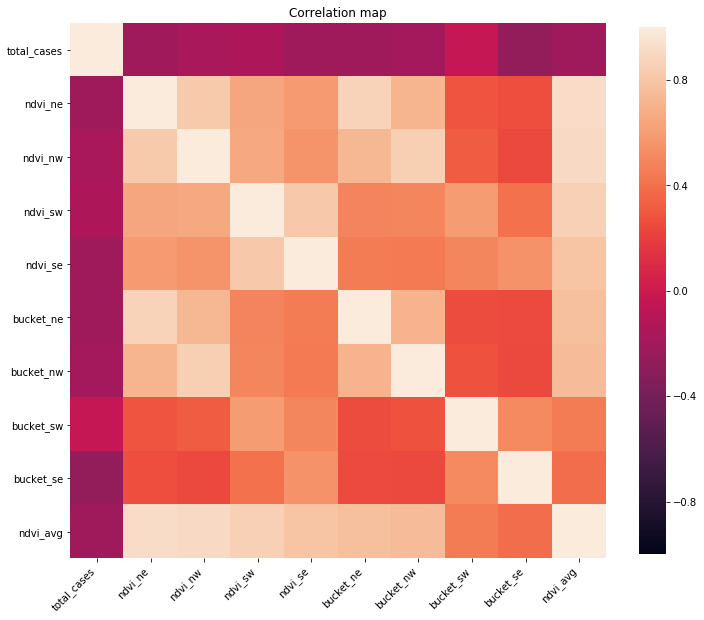

In [5]:
# convert to vector column first
vector_col = "features"
col_names = ['total_cases',
             'ndvi_ne', 'ndvi_nw', 'ndvi_sw', 'ndvi_se',
             'bucket_ne', 'bucket_nw', 'bucket_sw', 'bucket_se',
             'ndvi_avg'
             ]

assembler = VectorAssembler(inputCols=col_names, outputCol=vector_col)

# all
df = df_train
df_vector = assembler.transform(df).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)
array = matrix.collect()[0]["pearson({})".format(vector_col)].values

# convert (small) correlation matrix to pandas dataframe for visualization
corr_df = pd.DataFrame(
    np.reshape(array, (len(col_names), len(col_names))),
    index=col_names,
    columns=col_names)

# make plot
fig = plt.figure(figsize=(12, 10))
plt.title('Correlation map')

ax = sns.heatmap(corr_df, square=True,
                 xticklabels=True, yticklabels=True,
                 vmin=-1.0, vmax=1.0,
                 cbar_kws={"shrink": .97})

ax.set_xticklabels(ax.get_xticklabels(), rotation=45.0,
                   horizontalalignment='right')

# to fix bug in sns.heatmap (matplotlib 3.11)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

### Construction des jeux d'entrainement et de test

In [6]:
# San Juan (sj)
df_train_sj = df_train.filter(df_train.city == 'sj')
min_date_sj, max_date_sj = df_train_sj.select(F.min("week_start_date"),
                                              F.max("week_start_date")).first()

print("San Juan data:")
print("df_train_sj = ({}, {})".format(df_train_sj.count(), len(df_train_sj.columns)))
print("\tdate_start = {} / date_stop = {}".format(min_date_sj, max_date_sj))

# Iquitos (iq)
df_train_iq = df_train.filter(df_train.city == 'iq')
min_date_iq, max_date_iq = df_train_iq.select(F.min("week_start_date"),
                                              F.max("week_start_date")).first()

print("Iquitos data:")
print("df_train_iq = ({}, {})".format(df_train_iq.count(), len(df_train_iq.columns)))
print("\tdate_start = {} / date_stop = {}".format(min_date_iq, max_date_iq))

San Juan data:
df_train_sj = (936, 29)
	date_start = 1990-04-30 / date_stop = 2008-04-22
Iquitos data:
df_train_iq = (520, 29)
	date_start = 2000-07-01 / date_stop = 2010-06-25


In [7]:
# split train (90%) and test (10%)

# San Juan (sj)
testsize_sj = int(0.1 * df_train_sj.count())
delta_sj = datetime.timedelta(weeks=testsize_sj)
cut_date_sj = max_date_sj - delta_sj

train_sj = df_train_sj.filter(df_train_sj.week_start_date <= cut_date_sj)
test_sj = df_train_sj.filter(df_train_sj.week_start_date > cut_date_sj)

print("train_sj = ({}, {})".format(train_sj.count(), len(train_sj.columns)))
print("test_sj = ({}, {})".format(test_sj.count(), len(test_sj.columns)))

# Iquitos (iq)
testsize_iq = int(0.1 * df_train_iq.count())
delta_iq = datetime.timedelta(weeks=testsize_iq)
cut_date_iq = max_date_iq - delta_iq

train_iq = df_train_iq.filter(df_train_iq.week_start_date <= cut_date_iq)
test_iq = df_train_iq.filter(df_train_iq.week_start_date > cut_date_iq)

print("train_iq = ({}, {})".format(train_iq.count(), len(train_iq.columns)))
print("test_iq = ({}, {})".format(test_iq.count(), len(test_iq.columns)))

train_sj = (843, 29)
test_sj = (93, 29)
train_iq = (468, 29)
test_iq = (52, 29)


In [8]:
# concatanate the 2 sets
train = train_sj.union(train_iq)
test = test_sj.union(test_iq)

print("train = ({}, {})".format(train.count(), len(train.columns)))
print("test = ({}, {})".format(test.count(), len(test.columns)))

train = (1311, 29)
test = (145, 29)


### Construction du *pipeline*

In [9]:
# OneHotEncoder categorial variables
indexer = StringIndexer(inputCol='city', outputCol='city_')
encoder = OneHotEncoder(inputCol='city_', outputCol='cityVect')

# Build feature vector
vectorAssembler = VectorAssembler(
    inputCols=['cityVect',
               'year', 'weekofyear',
               'bucket_ne', 'bucket_nw', 'bucket_se', 'bucket_sw',
               'ndvi_avg',
               'reanalysis_precip_amt_kg_per_m2',
#               'reanalysis_relative_humidity_percent',
               'reanalysis_sat_precip_amt_mm',
               'reanalysis_specific_humidity_g_per_kg',
               'station_avg_temp_c',
               'station_diur_temp_rng_c',
               'station_max_temp_c', 'station_min_temp_c', 
               'station_precip_mm',  
               'reanalysis_air_temp_c',
               'reanalysis_avg_temp_c',
               'reanalysis_dew_point_temp_c',
               'reanalysis_max_air_temp_c',
#               'reanalysis_min_air_temp_c',
#               'reanalysis_tdtr_c',
               ], 
    outputCol = 'features')

# selected features
#vectorAssembler2 = VectorAssembler(
#    inputCols=['cityVect',
#               'year', 'weekofyear',
#               'reanalysis_specific_humidity_g_per_kg', 
#               'reanalysis_dew_point_temp_c', 
#               'station_avg_temp_c', 
#               'station_min_temp_c',
#               'reanalysis_min_air_temp_c',
#               'reanalysis_max_air_temp_c'], 
#    outputCol = 'features')

# scaler
scaler = StandardScaler(inputCol='features',
                        outputCol='scaled_features',
                        withStd=True, withMean=True)

# Random forest
rf = RandomForestRegressor(featuresCol='scaled_features',
                           labelCol='total_cases',
                           predictionCol='rf_prediction')

### Modèle *Random Forest* (forêt aléatoire)

#### Paramètres par défaut

In [10]:
pipeline_rf = Pipeline(stages=[indexer, encoder, vectorAssembler, scaler, rf])

evaluator_rf = RegressionEvaluator(labelCol='total_cases',
                                   predictionCol='rf_prediction',
                                   metricName="mae")

# build model
model_rf = pipeline_rf.fit(train)

# Build prediction from 'test' dataset
pred_rf = model_rf.transform(test)

#pred_rf.select(['total_cases','rf_prediction']).show(52)

mae = evaluator_rf.evaluate(pred_rf)

print("Random Forest::Before grid search - MAE = {:.3f}".format(mae))

Random Forest::Before grid search - MAE = 13.893


#### Ajustement des hyper-paramètres (*grid search*)

In [11]:
#numTrees = [15, 20, 25, 30, 40, 50, 60]
numTrees = [30, 35, 40, 45, 50, 55]
#maxDepths = [2, 4, 5, 7, 10, 15, 20]
maxDepths = [3, 4, 5, 6, 7, 8]

evaluator_rf = RegressionEvaluator(labelCol='total_cases',
                                   predictionCol='rf_prediction',
                                   metricName="mae")

rf_bestModel = model_rf
best_mae = mae

for nTree in numTrees:
    for depth in maxDepths:

        rf = RandomForestRegressor(featuresCol='scaled_features',
                                   labelCol='total_cases',
                                   predictionCol='rf_prediction',
                                   numTrees=nTree,
                                   maxDepth=depth)

        pipeline = Pipeline(stages=[indexer, encoder, vectorAssembler, scaler, rf])

        # build model
        model = pipeline.fit(train)

        # Build prediction from 'test' dataset
        pred = model.transform(test)

        mae = evaluator_rf.evaluate(pred)
        if mae < best_mae:
            best_mae = mae
            rf_bestModel = model

pred_rf = rf_bestModel.transform(test)

mae = evaluator_rf.evaluate(pred_rf)

numTree = rf_bestModel.stages[-1].getNumTrees
maxDepth = rf_bestModel.stages[-1]._java_obj.getMaxDepth()

print("Best model (numTree={}, MaxDepth={}) => MAE = {:.3f}".format(numTree, maxDepth, mae))

Best model (numTree=30, MaxDepth=4) => MAE = 13.304


#### Affichage des predictions obtenues

Nous mesurons la performance du modèle en ragardant les prédictions sur le jeu de données d'entrainement.

In [12]:
pd_train_sj = train_sj.toPandas()
pd_train_iq = train_iq.toPandas()


# create pandas dataframe from spark dataframe
pd_pred_rf = pred_rf.toPandas()

pd_pred_rf_sj = pd_pred_rf[pd_pred_rf['city'] == 'sj']
pd_pred_rf_iq = pd_pred_rf[pd_pred_rf['city'] == 'iq']

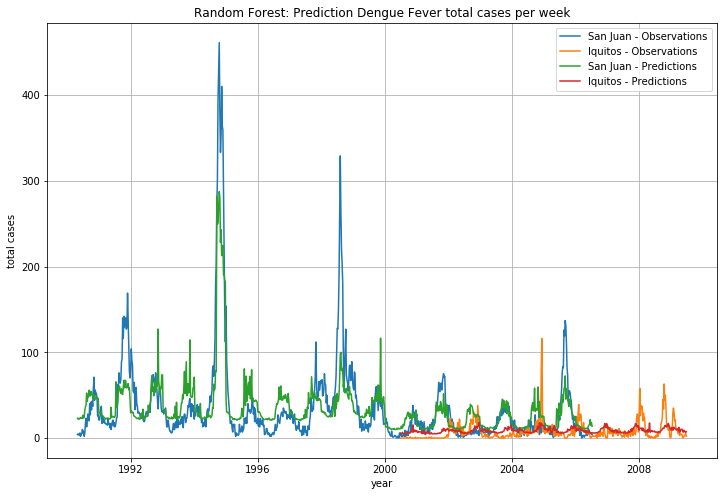

In [13]:
pred_train = rf_bestModel.transform(train)

# create pandas dataframe from spark dataframe
pd_pred_train = pred_train.toPandas()

pd_pred_train_sj = pd_pred_train[pd_pred_train['city'] == 'sj']
pd_pred_train_iq = pd_pred_train[pd_pred_train['city'] == 'iq']

# Total cases per city
fig = plt.figure(figsize=(12, 8))
plt.grid()
plt.title('Random Forest: Prediction Dengue Fever total cases per week')

plt.xlabel('year')
plt.ylabel('total cases')
plt.xticks()
plt.yticks()

plt.plot(pd_train_sj['week_start_date'], pd_train_sj['total_cases'],
         label='San Juan - Observations')
plt.plot(pd_train_iq['week_start_date'], pd_train_iq['total_cases'],
         label='Iquitos - Observations')

plt.plot(pd_pred_train_sj['week_start_date'], pd_pred_train_sj['rf_prediction'],
         label='San Juan - Predictions')
plt.plot(pd_pred_train_iq['week_start_date'], pd_pred_train_iq['rf_prediction'],
         label='Iquitos - Predictions')

plt.legend()

fig.savefig("figs/04-fig_01.jpg")
plt.show()

### Sauvegarde des données après *feature engineering*

In [14]:
print("Size of data = ({}, {})".format(df_train.count(), len(df_train.columns)))

# save preprocessed dataframe
path_to_dir = "data/02-featureEngineering"

if os.path.exists(path_to_dir) and os.path.isdir(path_to_dir):
    shutil.rmtree(path_to_dir)
    
df_train.write.parquet(path_to_dir)

Size of data = (1456, 29)


### Préparation du jeu de données test fourni par le "challenge"

In [15]:
# load data
df_bench = spark.read.parquet("data/01-benchmark")

# display information
print("df_bench = ({}, {})".format(df_bench.count(), len(df_bench.columns)))

#df_bench.printSchema()

df_bench = (416, 23)
root
 |-- city: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- weekofyear: integer (nullable = true)
 |-- week_start_date: date (nullable = true)
 |-- ndvi_ne: float (nullable = true)
 |-- ndvi_nw: float (nullable = true)
 |-- ndvi_se: float (nullable = true)
 |-- ndvi_sw: float (nullable = true)
 |-- reanalysis_precip_amt_kg_per_m2: float (nullable = true)
 |-- reanalysis_relative_humidity_percent: float (nullable = true)
 |-- reanalysis_sat_precip_amt_mm: float (nullable = true)
 |-- reanalysis_specific_humidity_g_per_kg: float (nullable = true)
 |-- station_avg_temp_c: float (nullable = true)
 |-- station_diur_temp_rng_c: float (nullable = true)
 |-- station_max_temp_c: float (nullable = true)
 |-- station_min_temp_c: float (nullable = true)
 |-- station_precip_mm: float (nullable = true)
 |-- reanalysis_air_temp_c: double (nullable = true)
 |-- reanalysis_avg_temp_c: double (nullable = true)
 |-- reanalysis_dew_point_temp_c: double (nullable

In [17]:
# clean data
df_bench = ndvi_bucketize(df_bench)
df_bench = ndvi_average(df_bench)

In [18]:
# save preprocessed dataframe
path_to_dir = "data/02-benchmark"

if os.path.exists(path_to_dir) and os.path.isdir(path_to_dir):
    shutil.rmtree(path_to_dir)

df_bench.write.parquet(path_to_dir)